# pydca demo

## MSA Trimming
Here we show how to use pydca as a library. We start with by importing pydca or selected modules within pydca.

In [1]:

# import system packages
import os.path, sys
import timeit
from pathlib import Path
from joblib import Parallel, delayed
import warnings

# import scientific computing packages
import numpy as np
np.random.seed(1)
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# import biopython packages
from Bio.PDB import *
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

# import pydca modules
import pydca
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca import dca_utilities
import os
import pandas as pd
import numpy as np

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import pdb2msa, data_processing
import tools as tools
from pathlib import Path


print(os.getcwd())
n_cpu = 18
method = "DI"
preprocess = False # do we want to preprocess FASTA files the same way as in DCA-ER method?

/gpfs/gsfs8/users/cresswellclayec/ER_DCA


## Define Data directories
* data_path: path to where Pfam MSA files are (assuming they are in .npy format)

In [2]:
create_new = True
printing = True
removing_cols = True


# Define data directories -- NEED TO DEFINE
data_path = Path('example_protein_data')
DCA_ER_dir = '.' # Set DCA_ER directory
out_dir = '%s/protein_data/di/' % DCA_ER_dir
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_ER_dir
pdb_dir = '%s/protein_data/pdb_data/' % DCA_ER_dir

# define path to PDB file (ent.gz format)
pdb_path = "%s/pdb1zdr.ent.gz" % data_path
print('\n\nUnzipping %s' % pdb_path)


# Define function to unzip pdb file
import gzip, shutil
def gunzip(file_path, output_path):
    print('Unzipping %s to %s' % (file_path, output_path))
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)


unzipped_pdb_filename = os.path.basename(pdb_path).replace(".gz", "")

pdb_out_path = "%s%s" % (pdb_dir, unzipped_pdb_filename)
print('Unzipping %s to %s' % (pdb_path, pdb_out_path))

gunzip(pdb_path, pdb_out_path)
print(pdb_out_path)
print(pdb_dir)






Unzipping example_protein_data/pdb1zdr.ent.gz
Unzipping example_protein_data/pdb1zdr.ent.gz to ./protein_data/pdb_data/pdb1zdr.ent
Unzipping example_protein_data/pdb1zdr.ent.gz to ./protein_data/pdb_data/pdb1zdr.ent
./protein_data/pdb_data/pdb1zdr.ent
./protein_data/pdb_data/


## PDB --> MSA pipeline
* Example of the PDB --> MSA pipeline which finds the best matching Pfam with a given PDB structure
    * For our example 1zdr --> PF00186

In [3]:
pdb2msa_results = pdb2msa(pdb_out_path, pdb_dir, create_new=False)
print(pdb2msa_results)

prody_df = pdb2msa_results[0]


print('\nPDB DF with associated Protein Families\n', prody_df.loc[:,  [column for column in prody_df.columns if column not in ['locations', 'PDB Sequence']]].head())


# since pdb2msa link was already found with ER run we just need to take it and process for PYDCA
pdb2msa_row  = prody_df.iloc[0]
print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
#try:
print(pdb2msa_row)
pfam_id = pdb2msa_row['Pfam']
pdb_id = pdb2msa_row['PDB ID']
pdb_chain = pdb2msa_row['Chain']
msa_outfile, ref_outfile, s, tpdb, removed_cols, s_index, pdb_s_index = tools.npy2fa(data_path, pdb2msa_row, pdb_dir, index_pdb=0, n_cpu=4, create_new=True, processed_data_dir=processed_data_dir) # letter_format is True
print(ref_outfile)
ref_outfile
print('Done Preprocessing Data.....')

[   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0             0               0                 0   
1           1             1               1                 1   

   Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1  \
0                   0                     0                       0   
1                   1                     1                       1   

   Unnamed: 0.1.1.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1.1.1  \
0                         0                           0   
1                         1                           1   

   Unnamed: 0.1.1.1.1.1.1.1.1.1  ...  ali_end  ali_start  bitscore  end  \
0                             0  ...      160          1    215.11  160   
1                             1  ...      160          1    215.08  160   

    cond_evalue    ind_evalue    evidence  hmm_end  hmm_start  start  
0  2.300000e-68  4.500000e-64  hmmer v3.0      160          1      1  
1  2.300000e-68  4.600000e-64  hmmer v3.0  

Original Sequence length:  918


#--------------------- Find PDB Sequence in MSA ---------------#
Lets find the reference sequence in this MSA
...We want index of the MSA sequence which best matches our PDB-polypeptide sequence...?
PDB-polypeptids sequence (len 160):
MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKTFEAIGRPLPGRDNVVVTGNRSFRPEGCLVLHSLEEVKQWIASRADEVFIIGGAELFRATMPIVDRLYVTKIFASFPGDTFYPPISDDEWEIVSYTPGGKDEKNPYEHAFIIYER


Looping through MSA sequences to find best matching sequence for our MSA reference sequence!
    ... found a match upgrade at index  0
MI---SH-IV---AMD-ENRVIGKD-NRLPWHLPADLAYFKRVTMGHAIVM-GRK-T---FEAIG----RPLPG-RD-NVVV-TGNR---SFR-PEGC--LVLH-S----L---E------EVKQWIASRADEVFIIGGAE--LFR---ATM------PIVDRLYV-TK-IFAS---FPGD--TFYP-PISD-DEWE----I----V-SYTPGGKDEKNP-Y----EHAFII----YER-
|    |  |    |   |    ||  |          |    |     |   ||  |   |        ||||  |  |||| |      |   |||   ||   |    |   |      ||        ||||||||    |     |        | | |||  |  |      |  |  ||   | |  

...found 205 duplicates! (Removing...)
#--------------------------------------------------------------#


After removing bad sequences, tpdb is now  68
1010
After removing bad sequences, tpdb is now  54

After removing bad sequences...
tpdb (s_ipdb) is :  54
(6535, 159)
Found bad columns := [  0  88 143 144 157 158]
Found conserved columns (80% repetition):
 [  6  13  14  21  26  30  34  41  42  43  45  48  53  54  56  60  95  96
 113 122 126]
We remove conserved and bad columns with, at the following indices (len 27):
 [  0   6  13  14 143 144  21  88  26 157  30 158  95  96  34  41  42  43
  45  48 113  53  54  56 122  60 126]
1
After removing bad sequences, tpdb is now  54
./protein_data/data_processing_output
Reference sequence (tpdb, s_ipdb) is sequence # 54
shape of s:  (6534, 159)
shape of ref_s:  (159,)
159
protein_data/data_processing_output/PF00186_ref.fa
Done Preprocessing Data.....


In the above, we have imported pydca or selected modules from pydca. Then we found our matching MSA given our PDB structure and acquired a reference sequence fasta files (generated from orignal parsed sequences in numpy format). Following that we will now creat an MSATrimmer instance which will enable us to trim the MSA file  to PYDCA format. Finally, we write the trimmed MSA data to an trimmed output file  in FASTA format. Next we carry out DCA computations using the PYDCA-trimmed MSA.

## DCA Computation Using Pseudolikelihood Maximization Algorithm (plmDCA)

In [4]:
# Compute DCA scores using Pseudolikelihood maximization algorithm
# create MSATrimmer instance 
trimmer = msa_trimmer.MSATrimmer(
    str(msa_outfile), biomolecule='protein',
    refseq_file=str(ref_outfile),
)

trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)

#write trimmed msa to file in FASTA format
trimmed_data_outfile = '%s/MSA_%s_trimmed.fa' % (processed_data_dir, pfam_id)
with open(trimmed_data_outfile, 'w') as fh:
    for seqid, seq in trimmed_data:
        fh.write('>{}\n{}\n'.format(seqid, seq))

In [5]:
plmdca_inst = plmdca.PlmDCA(
    trimmed_data_outfile,
    'protein',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads =n_cpu,
    max_iterations = 500,
)


plm_out_file = '%s%s_PLM_di.npy' % (out_dir, pfam_id)

if os.path.exists(plm_out_file):
    plmdca_scores = np.load(plm_out_file)
else:
    plmdca_scores = plmdca_inst.compute_sorted_DI()


In the above, we created a PlmDCA instance `plmdca_inst`  for RNA. Notice that we used the trimmed MSA data we obtained before.  We also set the values of optional parameters. The optional parameters `num_threads` is set to 10. If `pydca` is installed without OpenMP support, we cannot set the number of threads more than one. Finally we computed the DCA scores from the Frobenius norm of the couplings by calling the `compute_sorted_FN_APC()` method on `plmdca_inst`. This action returns the average product corrected (APC) DCA scores. Let us print the top five site pairs and their DCA scores.

In [6]:
# for site_pair, score in plmdca_scores[:5]:
#     print(site_pair, score)
# Save the scores for future use/comparison
np.save(plm_out_file, plmdca_scores)

We have displayed the top five site pairs ranked by their DCA scores. The first column is a tuple of site-pairs and the second column contains the DCA scores obtained from the Frobenius norm of the couplings. Note that the site pairs are arranged in the form (i, j) such that j > i.

## DCA Computation Using Mean-Field Algorithm (mfDCA)

In [7]:
#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    trimmed_data_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,

)


mf_out_file = '%s%s_PMF_di.npy' % (out_dir, pfam_id)

if os.path.exists(mf_out_file):
    mfdca_scores = np.load(mf_out_file)
else:
    mfdca_scores = mfdca_inst.compute_sorted_DI()


        


In the above, we created a mean-field DCA instance `mfdca_inst`. We set the optional parameters `pseudocount` and `seqid` to be `0.5` and `0.8`, respectively. Like in the plmDCA we computed the DCA scores from the Frobenius norm of the couplings and average product corrected. using `compute_sorted_FN_APC` method of `mfdca_inst`. Let us print the top five ranked site pairs.

In [8]:
for site_pair, score in mfdca_scores[:5]:
    print(site_pair, score)
    
# Save the scores for future use/comparison
np.save(mf_out_file, mfdca_scores)

(12, 121) 0.39296311215689955
(57, 72) 0.2862649145900164
(135, 138) 0.2822177535019997
(5, 7) 0.2536941891496377
(49, 50) 0.22875156248052436


## Plotting Contact Map and True Positive Rates

Next  we plot the contact map and true positive rates of DCA scores computed using the two methods (plmDCA and mfDCA)
### Contact Map and True Positive Rate for PlmDCA Scores

In [9]:
# ---------------------- We need to get pdb information for the contact visualizer --------------------------#
# Define pdb-references for Protein Family

# -----------------------------------------------------------------------------------------------------------#


plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = plmdca_scores,
    linear_dist = 4,
    contact_dist = 5.0,
)

Now we have created an instance of `DCAVisualizer`. It takes the type of biomolecule ('rna') , PDB chain ('x'), PDB ID ('1y26'). In addition we have specified reference sequence file, list of sorted DCA scores, linear distance and contact distnace.  When we execute the above cell we see a warning `You didn't supply RNA secondary structure file`. Since supplying an RNA secondary structure file is optional, we can ignore the warning. Next we plot the contact map and true postive rates.


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


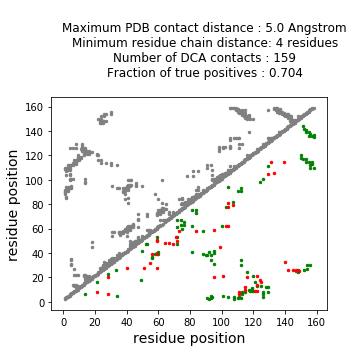

In [10]:
contact_map_data = plmdca_visualizer.plot_contact_map()


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


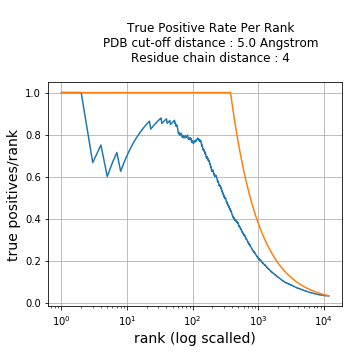

In [11]:
tp_rate_data = plmdca_visualizer.plot_true_positive_rates()

### Contact Map and True Positive Rate for Mean-Field DCA Scores

Like DCA scores computed using the plmDCA algorithm, we can visualize contact map and true positive rates for mfDCA computed DCA scores as shown below.

In [12]:
mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = mfdca_scores,
    linear_dist = 4,
    contact_dist = 5.0,
)


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


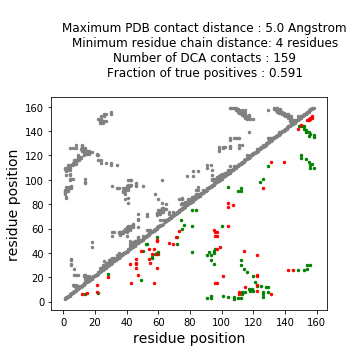

In [13]:
contact_map_data = mfdca_visualizer.plot_contact_map()


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


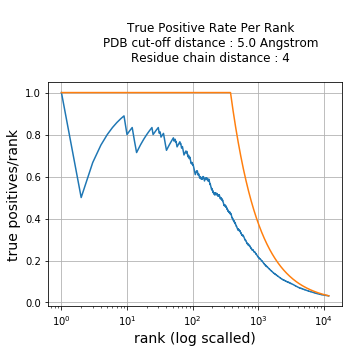

In [14]:
tp_rate_data = mfdca_visualizer.plot_true_positive_rates()

# Plot ER Results with PYDCA plotting
* This requires ER results (Run PDB2MSA.ipynb first)

In [15]:
ER_di = np.load("%s%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id))


s0 = np.load("%s/%s_%s_preproc_msa.npy" % (processed_data_dir, pfam_id, pdb_id))
s_index = np.load("%s/%s_%s_preproc_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
#pdb_s_index = np.load("%s/%s_%s_preproc_pdb_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
removed_cols = np.load("%s/%s_%s_removed_cols.npy" % (processed_data_dir, pfam_id, pdb_id))
ref_seq = np.load("%s/%s_%s_preproc_refseq.npy" % (processed_data_dir, pfam_id, pdb_id))




from tools import scores_matrix2dict

ER_scores = scores_matrix2dict(ER_di, s_index)


In [16]:
er_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = ER_scores,
    linear_dist = 4,
    contact_dist = 5.0,
)


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


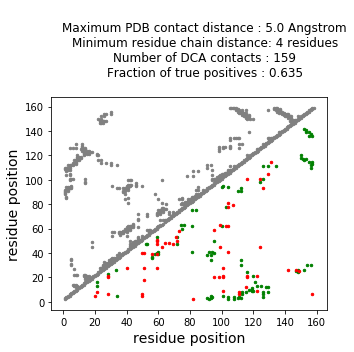

In [17]:
contact_map_data = er_visualizer.plot_contact_map()


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


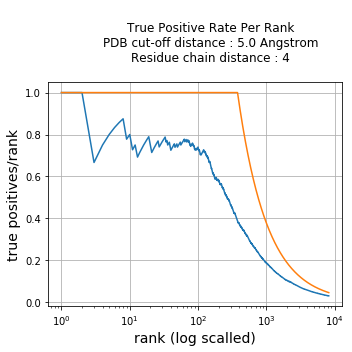

<Figure size 432x288 with 0 Axes>

In [18]:
tp_rate_data = er_visualizer.plot_true_positive_rates()
plt.savefig('%s_%s_tpRate.pdf' % (pdb_id, pfam_id))

In [19]:
ER_contact_categories = er_visualizer.contact_categories()



	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


In [20]:
print(len(ER_contact_categories['tp']))
print(len(ER_contact_categories['fp']))
for i, (key, value) in enumerate(ER_contact_categories['tp'].items()):
    if i > 5:
        break
    print(key, value)

101
58
(12, 121) ('CG1-CA', 13, 123, 3.5579123)
(35, 55) ('SD-O', 36, 56, 3.6790378)
(39, 58) ('CD1-OD1', 40, 59, 2.886563)
(61, 99) ('CG2-CD2', 62, 101, 4.124391)
(9, 116) ('OE1-C', 10, 118, 3.308217)
(37, 92) ('CG-CE1', 38, 94, 3.87336)
